In [151]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

## Загрузка и предварительная обработка датасета

Загружаем датасет и удаляем строки с пропущенными значениями

In [152]:
df = pd.read_csv('flights_NY.csv')
print(df.shape)
df.head()

(336776, 14)


,year,month,day,dep_time,dep_delay,arr_time,arr_delay,carrier,tailnum,flight,origin,dest,air_time,distance
0,2013,1,1,517.0,2.0,830.0,11.0,UA,N14228,1545,EWR,IAH,227.0,1400
1,2013,1,1,533.0,4.0,850.0,20.0,UA,N24211,1714,LGA,IAH,227.0,1416
2,2013,1,1,542.0,2.0,923.0,33.0,AA,N619AA,1141,JFK,MIA,160.0,1089
3,2013,1,1,544.0,-1.0,1004.0,-18.0,B6,N804JB,725,JFK,BQN,183.0,1576
4,2013,1,1,554.0,-6.0,812.0,-25.0,DL,N668DN,461,LGA,ATL,116.0,762


In [153]:
df.dropna(inplace=True)

Дату взлёта переводим в datetime

In [154]:
df.insert(0, 'date', pd.to_datetime(df[['year', 'month', 'day']]))
df = df.drop(['year', 'month', 'day'], axis=1)

Время взлёта и время прилёта переводим из float в datetime

In [155]:
def float_to_hm(time_float):
    hours = int(time_float // 100) % 24
    minutes = int(time_float % 100) % 60
    return f"{hours:02d}:{minutes:02d}"

# Приходится хранить значение по умолчанию '1900-01-01' для даты
df['dep_time'] = df['dep_time'].apply(float_to_hm)
df['dep_time'] = pd.to_datetime(df['dep_time'], format='%H:%M')

df['arr_time'] = df['arr_time'].apply(float_to_hm)
df['arr_time'] = pd.to_datetime(df['arr_time'], format='%H:%M')

In [156]:
df.head()

,date,dep_time,dep_delay,arr_time,arr_delay,carrier,tailnum,flight,origin,dest,air_time,distance
0,2013-01-01,1900-01-01 05:17:00,2.0,1900-01-01 08:30:00,11.0,UA,N14228,1545,EWR,IAH,227.0,1400
1,2013-01-01,1900-01-01 05:33:00,4.0,1900-01-01 08:50:00,20.0,UA,N24211,1714,LGA,IAH,227.0,1416
2,2013-01-01,1900-01-01 05:42:00,2.0,1900-01-01 09:23:00,33.0,AA,N619AA,1141,JFK,MIA,160.0,1089
3,2013-01-01,1900-01-01 05:44:00,-1.0,1900-01-01 10:04:00,-18.0,B6,N804JB,725,JFK,BQN,183.0,1576
4,2013-01-01,1900-01-01 05:54:00,-6.0,1900-01-01 08:12:00,-25.0,DL,N668DN,461,LGA,ATL,116.0,762


## Задание 1

Выберите 10 аэропортов, в которые чаще всего летают из Нью-Йорка. Для каждого  из них оцените вероятность, что рейс прилетит с положительной задержкой (arr_delay > 0) и постройте график (столбчатая диаграмма), на котором по оси х – название аэропорта, по оси y – вероятность задержки прилета. Названия аэропортов по оси х расположите слева направо по убыванию количества рейсов в этот аэропорт. Для какого аэропорта из этих 10 вероятность окажется наибольшей, и для какого – наименьшей? 

Выбираем 10 самых популярных аэропортов

In [157]:
popular_ports = df['dest'].value_counts().head(10).index
df_popular_ports = df[df['dest'].isin(popular_ports)]

Для каждого аэропорта оцениваем вероятность рейса с задержкой прилёта

In [158]:
delay_prob_estim = df_popular_ports.groupby('dest')['arr_delay'].apply(lambda x: (x > 0).mean())
delay_prob_estim = delay_prob_estim.reindex(popular_ports)

Строим график полученных оценок

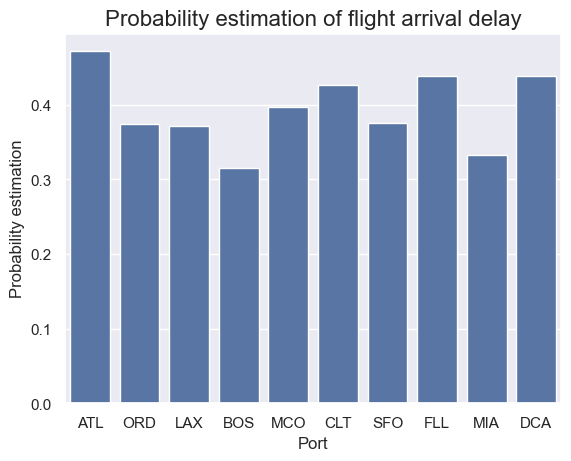

In [159]:
sns.set_theme()
sns.barplot(data=delay_prob_estim)

plt.title("Probability estimation of flight arrival delay", fontsize=16)
plt.xlabel("Port", fontsize=12)
plt.ylabel("Probability estimation", fontsize=12)
plt.show()

Найдём аэропорты с наибольшей и наименьшей вероятностями задержки прилёта

In [160]:
print(f" Наибольшая вероятность задержки прилёта наблюдается у {delay_prob_estim.idxmax()}: {delay_prob_estim.max(): .2f}")
print(f" Наименьшая вероятность задержки прилёта наблюдается у {delay_prob_estim.idxmin()}: {delay_prob_estim.min(): .2f}")

 Наибольшая вероятность задержки прилёта наблюдается у ATL:  0.47
 Наименьшая вероятность задержки прилёта наблюдается у BOS:  0.32


## Задание 2

2. Постройте нормированную гистограмму распределения времени перелета из Нью-Йорка в Сан-Франциско (SFO). Предполагая, что это распределение описывается нормальным законом, оцените параметры нормального закона и наложите график плотности полученного нормального закона на график с гистограммой. В каких пределах с вероятностью не менее 95% лежит время полета?

Выбираем время перелёта из Нью-Йорка в Сан-Франциско

In [161]:
SFO_airtime = df.loc[df['dest'] == 'SFO', 'air_time'].to_numpy()

Строим нормированную гистограмму

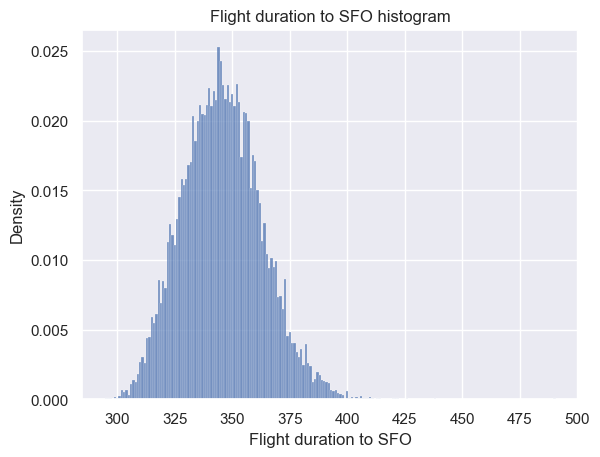

In [162]:
hist = sns.histplot(SFO_airtime, discrete=True, stat='density')
plt.title("Flight duration to SFO histogram")
plt.xlabel('Flight duration to SFO')
plt.show()

Вычисляем выборочное среднее и выборочную дисперсию

In [163]:
mu    = SFO_airtime.mean()
sigma = SFO_airtime.std(ddof=1) # Несмещённая 

Вычисляем доверительный интервал, используя квантили распределения Стьюдента c уровнем доверия 0.95

In [164]:
from scipy.stats import t, norm

p = 0.95
alpha = 1 - p
freedom_degree = len(SFO_airtime) - 1

lower_bound = mu - t.ppf(1 - alpha/2, freedom_degree) * sigma
upper_bound = mu + t.ppf(1 - alpha/2, freedom_degree) * sigma

Изобразим на графике плотность полученного нормального распределения и вычисленные границы

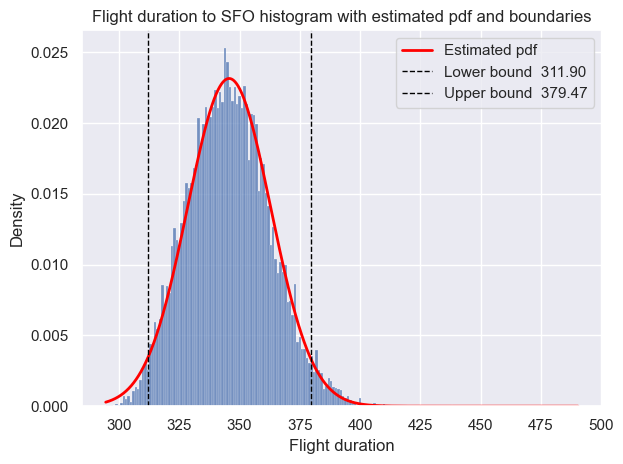

In [165]:
from scipy.stats import norm

hist = sns.histplot(SFO_airtime, discrete=True, stat='density')

bin_edges = hist.patches[0].get_x(), hist.patches[-1].get_x() + hist.patches[-1].get_width()
x = np.arange(bin_edges[0], bin_edges[1], 0.1)
pdf = norm.pdf(x, mu, sigma)

plt.plot(x, pdf, 'red', linewidth=2, label="Estimated pdf")
plt.axvline(lower_bound, color='black', linestyle='--', linewidth=1, label=f'Lower bound {lower_bound: .2f}')
plt.axvline(upper_bound, color='black', linestyle='--', linewidth=1, label=f'Upper bound {upper_bound: .2f}')
plt.title("Flight duration to SFO histogram with estimated pdf and boundaries")
plt.xlabel('Flight duration')
plt.tight_layout()
plt.legend()
plt.show()

## Задание 3

Нарисуйте распределение по часам (0-23) количества вылетов из аэропорта JFK и найдите два пиковых часа (один до полудня, другой – после полудня) по количеству вылетов (время вылета переводите в час вылета округлением вниз, например 7:20 -> 7, 16:45 -> 16). Для каждого из двух найденных пиковых часов найдите среднее время задержки вылетов в этот час. Когда средняя задержка больше? Будет ли это различие в средних значениях статистически значимо?

Выбираем аэропорт вылета JFK и строим гистограмму количества взлётов по часам (dt.hour отсекает минуты)

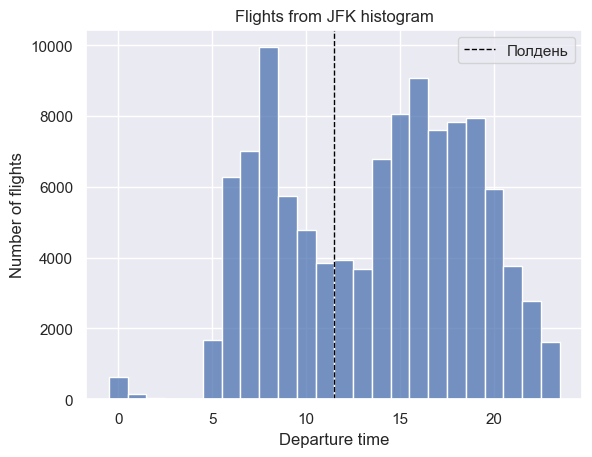

In [166]:
df_JFK = df.loc[df['origin'] == 'JFK']

sns.histplot(data=df_JFK['dep_time'].dt.hour, discrete=True)
plt.axvline(11.5, color='black', linestyle='--', linewidth=1, label='Полдень')
plt.xlabel('Departure time')
plt.ylabel('Number of flights')
plt.title('Flights from JFK histogram')
plt.legend()
plt.show()

In [167]:
am_peak = df_JFK['dep_time'].dt.hour.value_counts().sort_index().loc[0:11].idxmax()
pm_peak = df_JFK['dep_time'].dt.hour.value_counts().sort_index().loc[12:23].idxmax()

In [168]:
print(f"Пик до полудня: {am_peak}")
print(f"Пик после полудня: {pm_peak}")


Пик до полудня: 8
Пик после полудня: 16


Посчитаем среднюю задержку вылета для пиковых часов

In [169]:
dep_delays_am = df_JFK.loc[(df_JFK['dep_time'].dt.hour == am_peak) & (df_JFK['dep_delay'] >= 0)]['dep_delay'].to_numpy()
dep_delays_pm = df_JFK.loc[(df_JFK['dep_time'].dt.hour == pm_peak) & (df_JFK['dep_delay'] >= 0)]['dep_delay'].to_numpy()

mean_delay_am = dep_delays_am.mean()
mean_delay_pm = dep_delays_pm.mean()

print(f"Средняя задержка вылета в {am_peak: 2d}:{mean_delay_am: .2f} минут")
print(f"Средняя задержка вылета в {pm_peak:}:{mean_delay_pm: .2f} минут")

Средняя задержка вылета в  8: 14.28 минут
Средняя задержка вылета в 16: 24.42 минут


Средняя задержка во второй половине дня больше, чем утром. Можно предположить, что эта разница вызвана накопительным эффектом утренних задержек. Но так ли это?

Проведём t-тест Стьюдента, чтобы выяснить является ли эта разница статистически значимой. 

Чтобы использовать t-тест Стьюдента, необходимо убедится в том, что дисперсии двух выборок равны. Проведём тест Левена, чтобы проверить так это или не так.

In [170]:
from scipy.stats import levene

stat, p_value = levene(dep_delays_am, dep_delays_pm)
if p_value > 0.05:
    print("Дисперсии равны")
else:
    print("Дисперсии различаются")


Дисперсии различаются


Результат отрицательный, t-тест Стьюдента применять нельзя. Переобуваемся и используем тест Уэлча.

In [171]:
from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(dep_delays_am, dep_delays_pm, equal_var=False)

if p_value < 0.05:
    print("Различие статистически значимо")
else:
    print("Различие незначимо")

Различие статистически значимо


## Задание 4

Для каждого аэропорта прилета найдите величину стандартного отклонения времени перелета. Постройте график (точечная диаграмма) зависимости стандартного отклонения от расстояния до аэропорта. Аппроксимируйте полученную зависимость моделью линейной регрессии на основе расстояния до аэропорта  Добавьте к предыдущему графику график линейной регрессии. Уточните модель линейной регрессии, используя дополнительные входные признаки на основе расстояния до аэропорта. Добавьте график уточненной модели. Сравните точность моделей.

Выбираем из датасета нужные поля, считаем стандартное отклонение и расстояние. Поскольку аэропортов в Нью-Йорке 3, то возьмём за расстояние до назначения среднее.

In [172]:
df_std2dist = df.groupby('dest').agg(
    std  = ('air_time', 'std'),
    dist = ('distance', 'mean')
)
df_std2dist.dropna(inplace=True)

df_sorted = df_std2dist.sort_values('dist')

Изобразим данные на точечной диаграмме

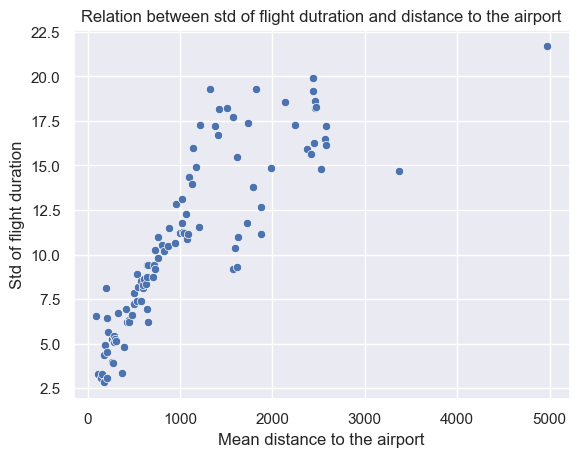

In [173]:
sns.scatterplot(data=df_sorted, x='dist', y='std')
plt.xlabel('Mean distance to the airport')
plt.ylabel('Std of flight duration')
plt.title('Relation between std of flight dutration and distance to the airport')
plt.show()

Воспользуемся средствами sklearn'a для линейной регрессии. Мерить качество будем метрикой r2.

In [174]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [175]:
X = df_sorted[['dist']]
y = df_sorted['std']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

score1 = r2_score(y, y_pred)
print(f"{score1 : .2f} для линейной регрессии")

 0.71 для линейной регрессии


Добавим прямую на точечную диаграмму

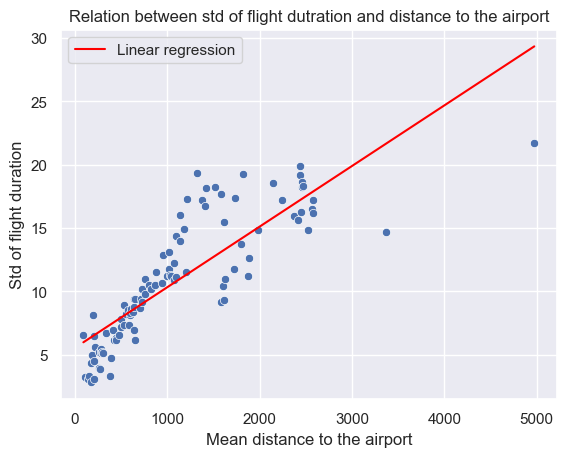

In [176]:
sns.scatterplot(data=df_sorted, x='dist', y='std')
plt.plot(X, y_pred, color='red', label='Linear regression')
plt.xlabel('Mean distance to the airport')
plt.ylabel('Std of flight duration')
plt.title('Relation between std of flight dutration and distance to the airport')
plt.legend()
plt.show()

Попытаемся улучшить качество регрессии, добавив новые признаки в выборку. 

In [177]:
# Сгенерируем дополнительные признаки

df_sorted['dist_sq']    = df_sorted['dist']**2
df_sorted['dist_sqrt']  = np.sqrt(df_sorted['dist'])


In [178]:

X = df_sorted[['dist', 'dist_sq', 'dist_sqrt']]  # Теперь 3 признака
y = df_sorted['std']

model = LinearRegression()
model.fit(X, y)

y_pred_2 = model.predict(X)
score2 = r2_score(y, y_pred_2)
print(f"{score2: .2f} для улучшенной линейной регрессии")

 0.81 для улучшенной линейной регрессии


Добавим улучшенный результат на график

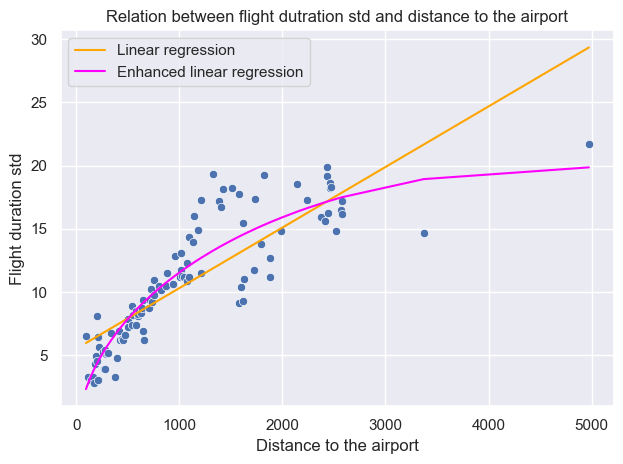

In [179]:
sns.scatterplot(data=df_sorted, x='dist', y='std')
plt.plot(df_sorted['dist'], y_pred, color='orange', label='Linear regression')
plt.plot(df_sorted['dist'], y_pred_2, color='magenta', label='Enhanced linear regression')
plt.xlabel('Distance to the airport')
plt.ylabel('Flight duration std')
plt.title('Relation between flight dutration std and distance to the airport')
plt.legend()
plt.tight_layout()
plt.show()

In [180]:
print(f"Точность первой модели {score1: .2f}, точность второй {score2: .2f}")

Точность первой модели  0.71, точность второй  0.81


## Задание 5

Методом кластерного анализа выделите три группы авиакомпаний на основе пары признаков: средняя задержка прилета и средняя задержка вылета. Постройте точечную диаграмму на этих признаках и раскрасьте точки в соответствии с номером кластера. Попробуйте дать интерпретацию кластерам (в этом может помочь название авиакомпании).

Выбираем из датасета нужную информацию

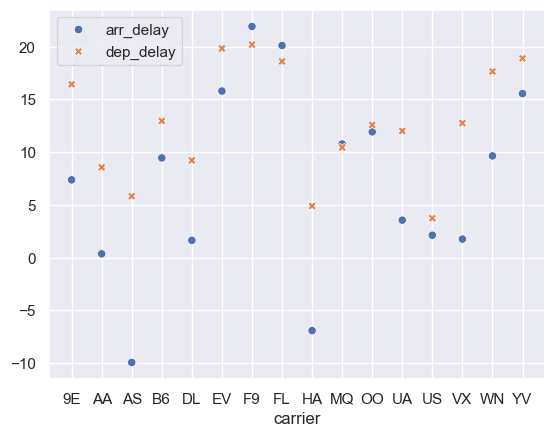

In [181]:
df_delay = df.groupby('carrier').agg(
    arr_delay = ('arr_delay', 'mean'),
    dep_delay = ('dep_delay', 'mean')
)
sns.scatterplot(df_delay)
plt.show()

Для построения кластеров воспользуемся алгоритмом KMeans 

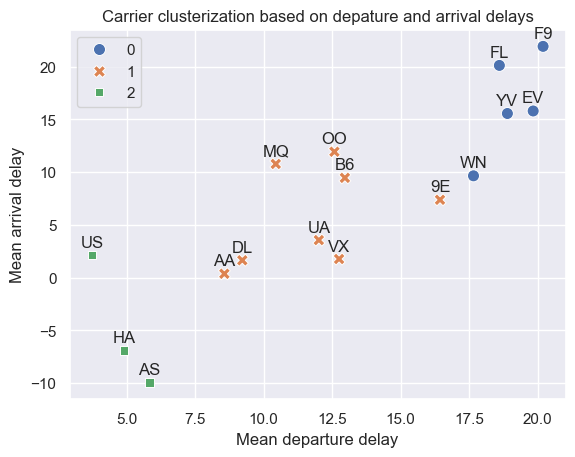

In [182]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_delay)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

sns.scatterplot(
    data    = df_delay,
    x       = 'dep_delay', 
    y       = 'arr_delay', 
    hue     = clusters, 
    style   = clusters,
    palette = 'deep',
    legend  = 'full',
    s       = 75
)

for i, abbr in enumerate(df_delay.index):
    plt.annotate(
        text       = abbr, 
        textcoords = "offset points",
        xytext     = (0,6),
        xy         = (df_delay['dep_delay'].iloc[i], df_delay['arr_delay'].iloc[i]),
        ha         = 'center'
    )

plt.title('Carrier clusterization based on depature and arrival delays')
plt.xlabel('Mean departure delay')
plt.ylabel('Mean arrival delay')
plt.show()

In [183]:
df_delay['cluster'] = clusters

df_clusters = df_delay.reset_index().groupby('cluster').agg({
    'dep_delay': ['mean', 'std'],
    'arr_delay': ['mean', 'std'],
    'carrier'  : 'count'
})

display(df_clusters)

dep_delay            arr_delay           carrier
              mean       std       mean       std   count
cluster                                                  
0        19.041329  1.011770  16.607829  4.762340       5
1        11.875668  2.488054   5.859315  4.571871       8
2         4.825342  1.045061  -4.905499  6.276385       3

В кластере 0 находятся авиакомпании с большими задержками, а в кластере 2 -- авиакомпании с минимальными задержками.

Кластер 2.
Авиакомпании AS ("Alaska Airlines") и HA ("Hawaiian Airlines") летают в Аляску и на Гавайи. Можно предположить, что загруженность аэропортов в этих локациях меньше, чем в магистральных. 
Здесь (https://en.wikipedia.org/wiki/Hawaiian_Airlines) написано, что "Hawaiian is the oldest American carrier that has never had a fatal accident or a hull loss and consistently ranks as the nation’s most punctual airline. It also leads in reliability metrics, including the fewest cancellations, overbookings, and baggage handling issues". То есть авиакомпания известна как самая пунктуальная.

Кластер 0.
Например F9 ("Frontier Airlines") является ультра бюджетной (https://en.wikipedia.org/wiki/Frontier_Airlines "ultra low-cost airline") и летает по всей Америке. 
WN ("Southwest Airlines") ещё один low-cost carrier. 

Итого: кластер 2 -- дорогие авикомпании. Кластер 0 (и отчасти кластер 1) -- бюджетные авиакомпании. Также роль играет размер флота и куда летают самолёты.